<a href="https://colab.research.google.com/github/harshjoshi23/AI1_Task1/blob/main/Notebbok_with_Early__stopping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1st

In [ ]:
# import torch
# import torchvision
# from torch.utils.data import DataLoader, Dataset
# from torchvision import transforms
# import torch.nn as nn
# import torch.optim as optim
# import os
# from PIL import Image
# import matplotlib.pyplot as plt
# import numpy as np

# # Check if GPU is available and set the device accordingly
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f'Using device: {device}')


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# # Define paths to dataset folders
# base_path = '/content/drive/My Drive/CamVid_Actual'
# train_images = os.path.join(base_path, 'train')
# train_labels = os.path.join(base_path, 'train_labels')
# test_images = os.path.join(base_path, 'test')
# test_labels = os.path.join(base_path, 'test_labels')
# val_images = os.path.join(base_path, 'val')
# val_labels = os.path.join(base_path, 'val_labels')

# Start

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define paths to dataset folders
base_path = '/content/drive/My Drive/CamVid_Actual'
train_images = os.path.join(base_path, 'train')
train_labels = os.path.join(base_path, 'train_labels')
test_images = os.path.join(base_path, 'test')
test_labels = os.path.join(base_path, 'test_labels')
val_images = os.path.join(base_path, 'val')
val_labels = os.path.join(base_path, 'val_labels')

In [ ]:


# Suppressing warnings for cleaner notebook presentation
import warnings
warnings.filterwarnings("ignore")

# base_path = '/content/drive/My Drive/CamVid_Actual'

# Class dictionary path
class_dict_path = os.path.join(base_path, "class_dict.csv")

# Load class dictionary
class_dict = pd.read_csv(class_dict_path)
print(class_dict.head())


        name    r    g    b
0     Animal   64  128   64
1    Archway  192    0  128
2  Bicyclist    0  128  192
3     Bridge    0  128   64
4   Building  128    0    0


In [ ]:

# Color mapping from CSV
color_to_class = {tuple(row[['r', 'g', 'b']].values): idx for idx, row in class_dict.iterrows()}
class_to_color = {idx: tuple(row[['r', 'g', 'b']].values) for idx, row in class_dict.iterrows()}

# Dataset paths
train_images_path = sorted([os.path.join(base_path, "train", x) for x in os.listdir(os.path.join(base_path, "train"))])
train_labels_path = sorted([os.path.join(base_path, "train_labels", x) for x in os.listdir(os.path.join(base_path, "train_labels"))])
val_images_path = sorted([os.path.join(base_path, "val", x) for x in os.listdir(os.path.join(base_path, "val"))])
val_labels_path = sorted([os.path.join(base_path, "val_labels", x) for x in os.listdir(os.path.join(base_path, "val_labels"))])

# Example transformation and dataset class
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
class CamVidDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None, label_transform=None):
        self.images_path = images_path
        self.labels_path = labels_path
        self.transform = transform
        self.label_transform = label_transform  # Separate transform for labels

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):
        image = Image.open(self.images_path[idx]).convert("RGB")
        label = Image.open(self.labels_path[idx])

        if self.transform:
            image = self.transform(image)

        if self.label_transform:
            label = self.label_transform(label)  # Apply label-specific transformations

        # Convert label to class indices using color mapping
        label = np.array(label, dtype=np.int32)  # Ensure using int32 for label indexing
        mask = np.zeros((label.shape[0], label.shape[1]), dtype=np.int64)
        for rgb, class_id in color_to_class.items():
            match = (label == np.array(rgb, dtype=np.int32)).all(axis=-1)
            mask[match] = class_id

        label = torch.from_numpy(mask)
        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

label_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST)  # Resize labels to match image size
])

train_dataset = CamVidDataset(train_images_path, train_labels_path, transform, label_transform)
val_dataset = CamVidDataset(val_images_path, val_labels_path, transform, label_transform)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)


Image batch shape: torch.Size([2, 3, 256, 256])
Label batch shape: torch.Size([2, 256, 256])


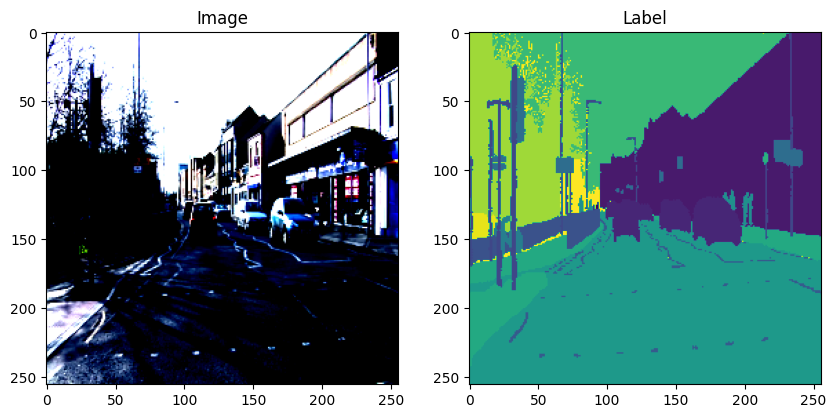

In [ ]:
# Quick check
for images, labels in train_loader:
    print(f"Image batch shape: {images.size()}")
    print(f"Label batch shape: {labels.size()}")
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(images[0].permute(1, 2, 0).numpy())
    plt.title("Image")
    plt.subplot(122)
    plt.imshow(labels[0].numpy())
    plt.title("Label")
    plt.show()
    break

In [ ]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = DoubleConv(64, 128)
        self.down2 = DoubleConv(128, 256)
        self.down3 = DoubleConv(256, 512)
        self.down4 = DoubleConv(512, 512)
        self.up1 = DoubleConv(1024, 256)
        self.up2 = DoubleConv(512, 128)
        self.up3 = DoubleConv(256, 64)
        self.up4 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(torch.cat([x4, x5], dim=1))
        x = self.up2(torch.cat([x3, x], dim=1))
        x = self.up3(torch.cat([x2, x], dim=1))
        x = self.up4(torch.cat([x1, x], dim=1))
        logits = self.outc(x)
        return logits

# Model initialization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=3, n_classes=len(class_dict)).to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
import torch

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, early_stopping_patience=10):
    best_val_loss = float('inf')
    epochs_no_improve = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'Using device: {device}')  # Check which device is being used
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct_train += (preds == masks).sum().item()
            total_train += masks.numel()

        train_accuracy = 100 * correct_train / total_train

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        iou_per_class = []
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                correct_val += (preds == masks).sum().item()
                total_val += masks.numel()

                for class_id in range(len(class_dict)):  # Make sure class_dict is defined
                    intersection = ((preds == class_id) & (masks == class_id)).float().sum()
                    union = ((preds == class_id) | (masks == class_id)).float().sum()
                    if union > 0:
                        iou_per_class.append(intersection / union)

        val_accuracy = 100 * correct_val / total_val
        average_iou = sum(iou_per_class) / len(iou_per_class) if iou_per_class else 0
        val_loss /= len(val_loader)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.3f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.3f}, Val Acc: {val_accuracy:.2f}%, Average IoU: {average_iou:.4f}')

        # Early stopping condition
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= early_stopping_patience:
            print('Early stopping!')
            break

# Example of calling train_model
train_model(model, train_loader, val_loader, criterion, optimizer)


Using device: cuda
Epoch 1/50, Train Loss: 1.006, Train Acc: 69.95%, Val Loss: 1.092, Val Acc: 67.24%, Average IoU: 0.1656
Epoch 2/50, Train Loss: 0.937, Train Acc: 72.06%, Val Loss: 0.973, Val Acc: 72.69%, Average IoU: 0.1912
Epoch 3/50, Train Loss: 0.893, Train Acc: 73.17%, Val Loss: 1.015, Val Acc: 71.06%, Average IoU: 0.1866
Epoch 4/50, Train Loss: 0.862, Train Acc: 74.12%, Val Loss: 0.873, Val Acc: 74.68%, Average IoU: 0.2087
Epoch 5/50, Train Loss: 0.824, Train Acc: 75.51%, Val Loss: 0.935, Val Acc: 74.15%, Average IoU: 0.2004
Epoch 6/50, Train Loss: 0.758, Train Acc: 77.50%, Val Loss: 0.824, Val Acc: 76.45%, Average IoU: 0.2205
Epoch 7/50, Train Loss: 0.744, Train Acc: 78.11%, Val Loss: 0.811, Val Acc: 76.91%, Average IoU: 0.2230
Epoch 8/50, Train Loss: 0.730, Train Acc: 78.37%, Val Loss: 0.747, Val Acc: 77.67%, Average IoU: 0.2414
Epoch 9/50, Train Loss: 0.696, Train Acc: 79.31%, Val Loss: 0.754, Val Acc: 78.09%, Average IoU: 0.2437
Epoch 10/50, Train Loss: 0.663, Train Acc: 80

In [ ]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    iou_per_class = []

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            test_loss += criterion(outputs, masks).item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == masks).sum().item()
            total += masks.numel()

            # Calculate IoU for each class
            for class_id in range(len(class_dict)):
                intersection = ((preds == class_id) & (masks == class_id)).float().sum()
                union = ((preds == class_id) | (masks == class_id)).float().sum()
                if union > 0:
                    iou_per_class.append(intersection / union)

    average_iou = sum(iou_per_class) / len(iou_per_class) if iou_per_class else 0
    test_accuracy = 100 * correct / total
    test_loss /= len(test_loader)

    print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.2f}%, Average IoU: {average_iou:.4f}')

# Example of calling evaluate_model
evaluate_model(model, test_loader, criterion)


In [ ]:
dump

In [ ]:
# import torch  looks overfitted / eaky
# import torch.nn.functional as F

# def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, early_stopping_patience=10):
#     best_val_loss = float('inf')
#     epochs_no_improve = 0

#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print(f'Using device: {device}')  # Check which device is being used
#     torch.cuda.empty_cache()  # Clear any cached data to ensure a clean run
#     model.to(device)

#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0
#         for images, masks in train_loader:
#             images, masks = images.to(device), masks.to(device)
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, masks)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()

#         # Evaluation phase
#         model.eval()
#         val_loss = 0
#         correct_val = 0
#         total_val = 0
#         iou_per_class = []
#         with torch.no_grad():
#             for images, masks in val_loader:
#                 images, masks = images.to(device), masks.to(device)
#                 outputs = model(images)
#                 val_loss += criterion(outputs, masks).item()

#                 preds = torch.argmax(outputs, dim=1)
#                 correct_val += (preds == masks).sum().item()
#                 total_val += masks.numel()

#                 # Calculate IoU
#                 for class_id in range(len(class_dict)):
#                     intersection = ((preds == class_id) & (masks == class_id)).float().sum()
#                     union = ((preds == class_id) | (masks == class_id)).float().sum()
#                     if union > 0:
#                         iou_per_class.append(intersection / union)

#         # Average IoU across classes
#         average_iou = sum(iou_per_class) / len(iou_per_class) if iou_per_class else 0
#         val_accuracy = 100 * correct_val / total_val
#         val_loss /= len(val_loader)

#         # Early stopping condition
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             epochs_no_improve = 0
#         else:
#             epochs_no_improve += 1

#         if epochs_no_improve >= early_stopping_patience:
#             print('Early stopping!')
#             break

#         if val_accuracy >= 90:
#             print('Reached 90% accuracy, stopping early!')
#             break

#         print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.3f}, Val Loss: {val_loss:.3f}, Val Acc: {val_accuracy:.2f}%, Average IoU: {average_iou:.4f}')

# # Example of calling train_model
# train_model(model, train_loader, val_loader, criterion, optimizer)


Using device: cuda
Epoch 1/50, Train Loss: 1.512, Val Loss: 1.252, Val Acc: 64.77%, Average IoU: 0.1410
Epoch 2/50, Train Loss: 1.132, Val Loss: 1.173, Val Acc: 64.76%, Average IoU: 0.1605


KeyboardInterrupt: 

Eval

In [ ]:
dump

In [ ]:
#Updated Training Function with Epoch Feedback and Accuracy
import torch

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += masks.nelement()
            correct_train += predicted.eq(masks.data).sum().item()

        train_accuracy = 100 * correct_train / total_train

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total_val += masks.nelement()
                correct_val += predicted.eq(masks.data).sum().item()

        val_accuracy = 100 * correct_val / total_val

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.3f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss / len(val_loader):.3f}, Val Acc: {val_accuracy:.2f}%')

# Assuming you have already defined 'model', 'train_loader', 'val_loader', 'criterion', and 'optimizer'
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


# Incomplete


In [ ]:
# # Training function with accuracy same above
# def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0
#         correct_train = 0
#         total_train = 0

#         for images, masks in train_loader:
#             images, masks = images.to(device), masks.to(device)
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, masks)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()

#             _, predicted = torch.max(outputs, 1)
#             total_train += masks.numel()
#             correct_train += (predicted == masks).sum().item()

#         train_accuracy = 100 * correct_train / total_train

#         model.eval()
#         val_loss = 0
#         correct_val = 0
#         total_val = 0
#         with torch.no_grad():
#             for images, masks in val_loader:
#                 images, masks = images.to(device), masks.to(device)
#                 outputs = model(images)
#                 loss = criterion(outputs, masks)
#                 val_loss += loss.item()

#                 _, predicted = torch.max(outputs, 1)
#                 total_val += masks.numel()
#                 correct_val += (predicted == masks).sum().item()

#         val_accuracy = 100 * correct_val / total_val

#         print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.3f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss / len(val_loader):.3f}, Val Acc: {val_accuracy:.2f}%')

# # Run the training
# train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


In [ ]:
dump

In [ ]:
# Model evaluation on a separate test set
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_test += masks.numel()
            correct_test += (predicted == masks).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f'Test Loss: {test_loss / len(test_loader):.3f}, Test Accuracy: {test_accuracy:.2f}%')

# Assuming test_loader is defined and set up similarly to train_loader and val_loader
evaluate_model(model, test_loader, criterion)


In [ ]:
import torch

# Model evaluation on a separate test set
def evaluate_model(model, test_loader, criterion, batch_size=32):
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0

    # Update DataLoader batch size if possible, or implement here manually if needed
    # test_loader.batch_size = batch_size  # Update this if your DataLoader supports dynamic batch sizes

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_test += masks.numel()
            correct_test += (predicted == masks).sum().item()

            # Clear cache after processing each batch to free up memory
            torch.cuda.empty_cache()

    test_accuracy = 100 * correct_test / total_test
    print(f'Test Loss: {test_loss / len(test_loader):.3f}, Test Accuracy: {test_accuracy:.2f}%')

# Assuming test_loader is defined and set up similarly to train_loader and val_loader
evaluate_model(model, test_loader, criterion)


In [ ]:
import torch
from torch.utils.checkpoint import checkpoint

def run_function(inputs):
    return model(inputs)

def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            # Using checkpointing during inference for memory efficiency
            outputs = checkpoint(run_function, images)
            loss = criterion(outputs, masks)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += masks.numel()
            correct_test += (predicted == masks).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f'Test Loss: {test_loss / len(test_loader):.3f}, Test Accuracy: {test_accuracy:.2f}%')

# Assuming test_loader is defined and set up similarly to train_loader and val_loader
evaluate_model(model, test_loader, criterion)


In [ ]:
#Updated Training Function with Epoch Feedback and Accuracy
import torch

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += masks.nelement()
            correct_train += predicted.eq(masks.data).sum().item()

        train_accuracy = 100 * correct_train / total_train

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total_val += masks.nelement()
                correct_val += predicted.eq(masks.data).sum().item()

        val_accuracy = 100 * correct_val / total_val

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.3f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss / len(val_loader):.3f}, Val Acc: {val_accuracy:.2f}%')

# Assuming you have already defined 'model', 'train_loader', 'val_loader', 'criterion', and 'optimizer'
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


In [ ]:
# Training function with accuracy same above
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += masks.numel()
            correct_train += (predicted == masks).sum().item()

        train_accuracy = 100 * correct_train / total_train

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += masks.numel()
                correct_val += (predicted == masks).sum().item()

        val_accuracy = 100 * correct_val / total_val

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.3f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss / len(val_loader):.3f}, Val Acc: {val_accuracy:.2f}%')

# Run the training
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


In [ ]:
s

In [ ]:
break

In [ ]:
# This is also shit below